In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cv2, os
import pandas as pd
from scipy.interpolate import interp1d
from scipy import interpolate
import torch

## Patch Hyperspectral Reflectance

Text(0.5, 0, 'wavelength [nm]')

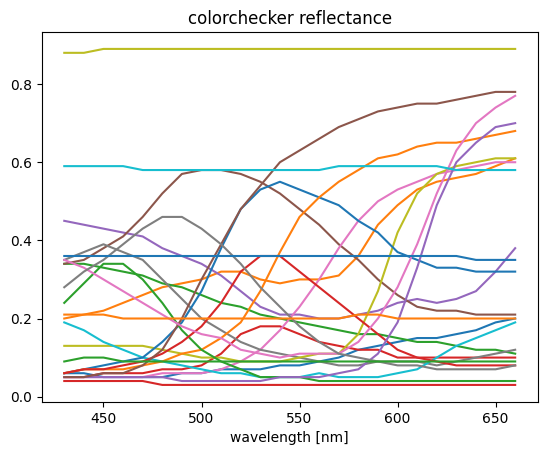

In [16]:
# Replace 'file.csv' with the path to your CSV file
file_path = './dataset/MacbethColorChecker.csv'
# Read the CSV file and store it as a DataFrame
df = pd.read_csv(file_path, header=None, skiprows=2)

# Display the DataFrame
wvls_CC = df.values[1:,0]
wvls_CC = [float(x) for x in wvls_CC] 
ref_CC = df.values[1:,1:-2]

ind_min = 6
ind_max = 61
wvls_CC = wvls_CC[ind_min:ind_max:2] 
ref_CC = ref_CC[ind_min:ind_max:2,:]

# print(wvls_CC, ref_CC)

plt.figure()
plt.plot(wvls_CC[2:-2], ref_CC[2:-2])
plt.title('colorchecker reflectance')
plt.xlabel('wavelength [nm]')

In [17]:
# blue = ref_CC[2:-2,12] 
# green = ref_CC[2:-2,13] 
# red = ref_CC[2:-2,14] 
# white = ref_CC[2:-2,18]

## ldr2hdr

In [18]:
# arguments
cam_H, cam_W = 580, 890
wvls = np.arange(430, 670, 10) # 430nm 부터 시작

n_illum = 318
n_patches = 24
n_channel = 3

patch_idx = np.arange(0, 24)
patch_size = 3

### Gamma correction

In [19]:
# # load gamma rgb fitting coefficients
# rgb_fit = io.loadmat("./calibration/gamma_correction.mat")

# # define coefficients for all rgb channel
# a = rgb_fit['a']
# b = rgb_fit['b']
# c = rgb_fit['c']

# # gamma correction
# y = a*(y_linear**b)+c

# # stack for 3 channels
# rgb_gamma_corrected = y

### ldr2hdr Preprocess

In [20]:
# date of datas
date = "1022"

idx_minmax = 1

# exposure time
ex_time = np.array([160, 320])
# ex_time = np.array([160, 280, 390])
ex_min = ex_time[idx_minmax]
exposure = ex_time / ex_min

# rgb intensity
# intensity = np.array([0.2, 0.8, 0.8])
intensity = np.array([0.2, 0.8])

# ldr2hdr_dir = "./calibration/ldr2hdr/2023%s/"%date
ldr2hdr_dir = "./dataset/data/2023%s_real_data/"%date

# # center points for all patches 20231003
# all_patches_center_pts = np.array([[200,160], [300,150], [418,142], [533,133],[651, 129], [770,100],
#                                     [200,276], [308,267], [420,260], [537,251], [655,245], [780,237],
#                                     [202,386], [310,382], [420,375], [540,375], [660,368], [780,360],
#                                     [200,500], [300,490], [420,500], [540,500], [660,490], [790,480]])

# # center points for all patches 20231016
# all_patches_center_pts = np.array([[187,206], [186,247], [187,286], [187,323],[187, 366], [187,405],
#                                     [150,207], [150,246], [145,284], [145,322], [145,365], [145,406],
#                                     [108,205], [108,243], [105,284], [104,326], [105,363], [104,402],
#                                     [68,203], [68,242], [68,283], [64,320], [63,362], [62,404]])

# center points for all patches 20231022
all_patches_center_pts = np.array([[293,120], [400,120], [500,120], [608,115],[717,116], [822,115],
                                    [293,227], [395,218], [507,220], [613,220], [720,220], [830,220],
                                    [290,320], [400,324], [500,327], [610,328], [720,324], [830,324],
                                    [288,432], [400,437], [500,436], [615,434], [722,435], [832,428]])

# # center points for all patches 20231022(2)
# all_patches_center_pts = np.array([[268,71], [368,94], [464,114], [560,130],[648,146], [730,163],
#                                     [260,190], [365,200], [460,220], [555,235], [644,252], [727,262],
#                                     [255,300], [360,324], [463,329], [555,343], [641,354], [723,361],
#                                     [251,432], [357,437], [458,443], [550,450], [641,457], [721,465]])

# # center points for all patches 20231002
# all_patches_center_pts = np.array([[120,80], [260,90], [390,90], [510,100], [640,100], [770,100],
#                                     [118,200], [250,200], [386,220], [510,220], [650,220], [770,220],
#                                     [115,339], [246,340], [380,340], [520,350], [640,350], [770,350],
#                                     [100,470], [240,480], [380,480], [510,480], [650,480], [770,480]])

# # # center points for all patches 20230926
# all_patches_center_pts = np.array([[144, 170], [255,180], [360,189], [467, 190], [575,200], [675,200],
# [140,280], [250,290], [360,290], [460,300], [570,300], [670,300],
# [140,390], [250,400], [360,400], [460,400], [570,410], [675,407],
# [133,500], [240,506], [350,500], [460,500], [570,500], [676,510]])

# black patch
# last_row_center_pts = np.array([128, 517])
# last_row_center_pts = np.array([62, 404])
# last_row_center_pts = np.array([721,465])
last_row_center_pts = np.array([830,428])

# last_row_center_pts = np.array([91, 533])

In [21]:
# safe subtraction for uint16
def safe_subtract(a,b):
    # difference = np.abs(a.astype(np.int16) - b.astype(np.int16))
    
    difference = np.where(a>b, a-b, 0)
    difference = np.clip(np.round(difference), 0, 65535).astype(np.uint16)    
    
    return difference.astype(a.dtype)

In [22]:
# radiance weight for intensity normalization
def cal_radiance_weight(exp_images_bgrm): # exposure 개수, H, W, 3
    radiance_values = np.zeros(shape=(len(exp_images_bgrm), 3))
    
    p_size = 5
    
    for i in range(len(exp_images_bgrm)):
        y_idx_start, y_idx_end = (last_row_center_pts[1] - p_size//2).astype(np.int32), (last_row_center_pts[1] + p_size//2).astype(np.int32)
        x_idx_start, x_idx_end = (last_row_center_pts[0] - p_size//2).astype(np.int32), (last_row_center_pts[0] + p_size//2).astype(np.int32)
        
        radiance_values[i] = exp_images_bgrm[i][y_idx_start:y_idx_end, x_idx_start:x_idx_end].mean(axis = (0,1))
    
    return (radiance_values / radiance_values[idx_minmax])

# calculate radiance_weight
exp_img_path = os.path.join(ldr2hdr_dir, 'intensity_%d_white_crop/calibration00/capture_%04d.png')
exp_img_black_path = os.path.join(ldr2hdr_dir, 'step2_%sms_black_crop/calibration00/capture_%04d.png')

exp_images = np.array([cv2.imread(exp_img_path%(intensity[k]*100, 0), -1)[:,:,::-1] for k in range(len(intensity))])
exp_black_images = np.array([cv2.imread(exp_img_black_path%(160, 0), -1)[:,:,::-1] for k in ex_time])

# remove black image
exp_images_bgrm = safe_subtract(exp_images, exp_black_images)

# radiance weight calculation
radiance_weight = cal_radiance_weight(exp_images_bgrm)

In [23]:
1/radiance_weight

array([[21.28390805, 21.35087719, 21.48548549],
       [ 1.        ,  1.        ,  1.        ]])

In [24]:
# assumes that we have the uint16 LDR images 
# image intensity weight

invalid_intensity_ratio = 0.01 # 0 < invalid_intensity_ratio: invalid,  out of 1

max_intensity = 2**16
weight_trapezoid = np.zeros(max_intensity)
intv = float(max_intensity) * invalid_intensity_ratio

for i in range(max_intensity):
    if i < intv:
        weight_trapezoid[i] = 0  
    elif i < intv * 2:
        weight_trapezoid[i] = (i - intv) / intv
    elif i < max_intensity - (intv * 2):
        weight_trapezoid[i] = 1
    elif i < max_intensity - intv:
        weight_trapezoid[i] = (max_intensity - intv - i) / intv
    else:
        weight_trapezoid[i] = 0

In [25]:
# assumes that we have the uint16 LDR images 
# black removed image intensity weight

invalid_intensity_ratio = 0.01  # 0 < invalid_intensity_ratio: invalid,  out of 1

max_intensity = 2**16
weight_trapezoid_bgrm = np.zeros(max_intensity)
intv = float(max_intensity) * invalid_intensity_ratio

for i in range(max_intensity):
    if i < intv: # 3 
        weight_trapezoid_bgrm[i] = 0  
    elif i < intv * 2:
        weight_trapezoid_bgrm[i] = (i - intv) / intv
    else:
        weight_trapezoid_bgrm[i] = 1

In [26]:
def make_hdr(ldr_images, ldr_images_bgrm, weight_trapezoid, exposure):
    
    # weighted images for ldr image and black image removed ldr image
    # black image를 뺀 애는 saturation이 일어난 ldr image에서 intensity가 내려가기 때문에 사실 
    # saturation이 일어나서 얘를 weight 를 0을 줘야함. 근데 bgrm에만 기준으로 weight가 정해지면
    # saturation 일어난 애에서 제거가 불가능
    weighted_images = [weight_trapezoid[image] for image in ldr_images]
    weighted_images_bgrm = [weight_trapezoid_bgrm[image] for image in ldr_images_bgrm]
    
    # take the minimum weight 
    weighted_images_final = np.minimum(weighted_images, weighted_images_bgrm)
    
    # exposure normalization
    # radiance_images = [np.multiply(weighted_images_final[i], ldr_images_bgrm[i]) for i in range(len(ldr_images_bgrm))]
    radiance_images = [np.multiply(weighted_images_final[i], ldr_images_bgrm[i] / (radiance_weight[i] * exposure[i])) for i in range(len(ldr_images_bgrm))]

    # intensity normalization
    weight_sum_image = np.sum(weighted_images_final, axis=0)
    radiance_sum_image = np.sum(radiance_images, axis=0)

    idx_invalid = (weight_sum_image == 0)
    weight_sum_image[idx_invalid] = 1
    radiance_sum_image[idx_invalid] = 0    
    
    return np.divide(radiance_sum_image, weight_sum_image), idx_invalid, weight_sum_image

#### Raidance weight debugging

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


original :  [3.1372549  5.52156863 3.63921569]
normalized :  [ 66.77304485 117.89033368  78.19031581]
original :  [ 67.38823529 124.7372549   81.81960784]
normalized :  [ 67.38823529 124.7372549   81.81960784]


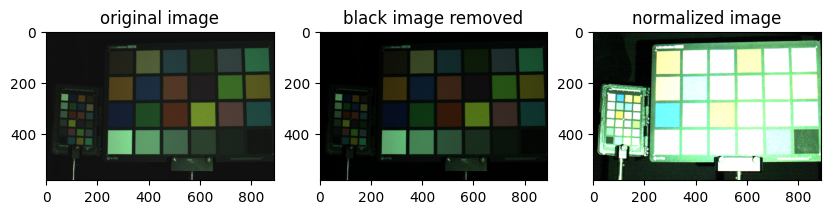

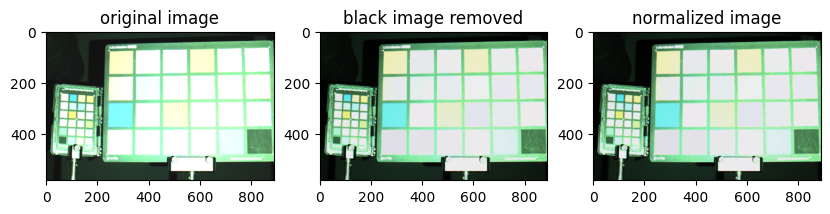

In [27]:
for i in range(len(exp_images)):
    plt.figure(figsize=(10, 5))
    plt.subplot(131), plt.imshow(exp_images[i]/65535), plt.title('original image')
    plt.subplot(132), plt.imshow((exp_images_bgrm[i]/ 65535)), plt.title('black image removed')
    plt.subplot(133), plt.imshow((exp_images_bgrm[i]*(1/radiance_weight[i]))/ 65535), plt.title('normalized image')
    print('original : ', (exp_images_bgrm[i][last_row_center_pts[1], last_row_center_pts[0]]/ 255))
    print('normalized : ', (exp_images_bgrm[i][last_row_center_pts[1], last_row_center_pts[0]] * (1/radiance_weight[i]))/ 255)

#### Debugging

In [14]:
ldr_path = os.path.join(ldr2hdr_dir, 'step2_%sms_crop/calibration00/capture_%04d.png')
black_path = os.path.join(ldr2hdr_dir, 'step2_%sms_black_crop/calibration00/capture_%04d.png')

i = 201

ldr_images = np.array([cv2.imread(ldr_path%(k, i), -1)[:,:,::-1] for k in ex_time])
ldr_black_images = np.array([cv2.imread(black_path%(k, 0), -1)[:,:,::-1] for k in ex_time])

ldr_images_bgrm = np.clip(safe_subtract(ldr_images, ldr_black_images), 0., 2**16)
ldr_images_bgrm = ldr_images_bgrm.astype(np.uint16)

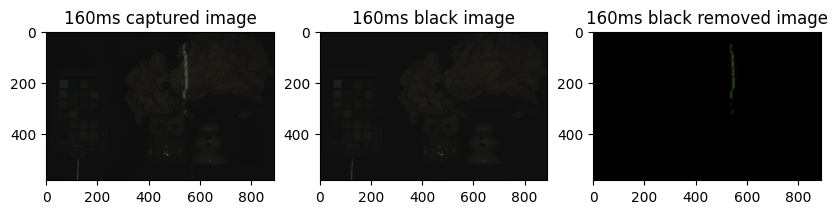

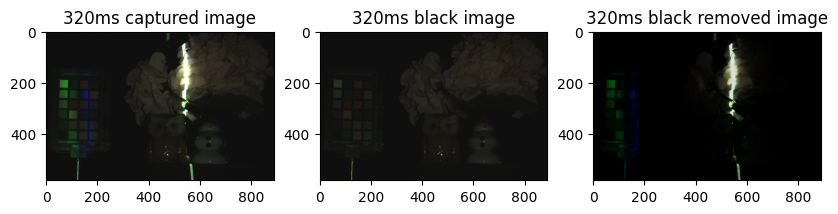

In [15]:
for i in range(len(ldr_images)):
    plt.figure(figsize=(10,5))
    plt.subplot(131),plt.imshow(ldr_images[i]/65535.), plt.title('%sms captured image'%ex_time[i])
    plt.subplot(132), plt.imshow(ldr_black_images[i]/65535.), plt.title('%sms black image'%ex_time[i])
    plt.subplot(133),plt.imshow(ldr_images_bgrm[i]/65535.), plt.title('%sms black removed image'%ex_time[i])

In [16]:
# for i in range(3):
#     plt.figure()
#     normalized_image = (ldr_images_bgrm[i] / (radiance_weight[i] * exposure[i]))/65535
#     plt.imshow(normalized_image)
    
#     print('original %sms'%ex_time[i])
#     print('black patch', ldr_images_bgrm[i,497,777]/65535 * 255.)
#     print('green dispersed patch', ldr_images_bgrm[i,488,309]/65535 * 255.)
    
#     print('normalized %sms'%ex_time[i])
#     print('black patch', normalized_image[497,777] * 255.)
#     print('green dispersed patch', normalized_image[488,309] * 255.)
    
#     print('\n')

In [17]:
#### 왜 weighted images가 필요한지
weighted_images = [weight_trapezoid[image] for image in ldr_images]
weighted_images_bgrm = [weight_trapezoid_bgrm[image] for image in ldr_images_bgrm]

weighted_images_final = np.minimum(weighted_images, weighted_images_bgrm)

# exposure weight, radiance weight 
# normalization 및 weight multiplication
radiance_images = [np.multiply(weighted_images_final[i], ldr_images_bgrm[i] / (radiance_weight[i] * exposure[i])) for i in range(len(ldr_images_bgrm))]

weight_sum_image = np.sum(weighted_images_final, axis=0)
radiance_sum_image = np.sum(radiance_images, axis=0)

idx_invalid = (weight_sum_image == 0)
weight_sum_image[idx_invalid] = 1
radiance_sum_image[idx_invalid] = 0 

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x233a9cd2c48>)

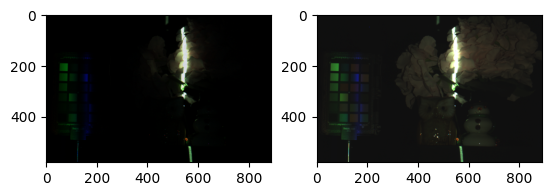

In [18]:
plt.subplot(121), plt.imshow(ldr_images_bgrm[1]/65535)
plt.subplot(122), plt.imshow(ldr_images[1]/65535)

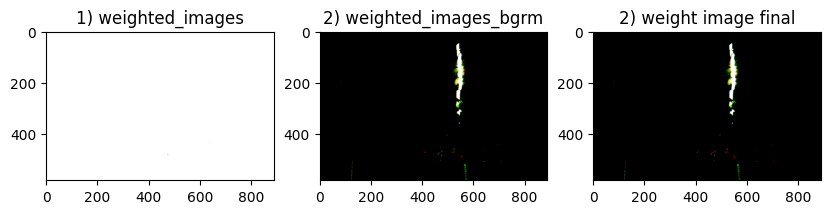

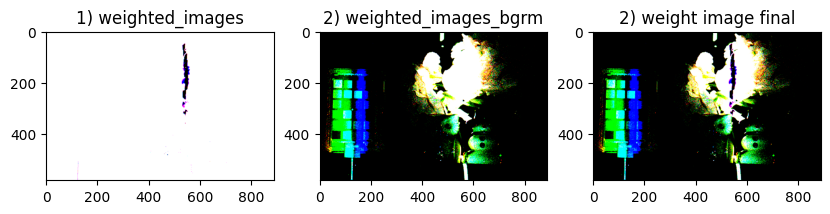

In [19]:
for i in range(len(ldr_images)):
    plt.figure(figsize = (10,5))
    plt.subplot(131), plt.imshow(weighted_images[i]), plt.title('1) weighted_images')
    plt.subplot(132), plt.imshow(weighted_images_bgrm[i]), plt.title('2) weighted_images_bgrm')
    plt.subplot(133), plt.imshow(weighted_images_final[i]), plt.title('2) weight image final')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


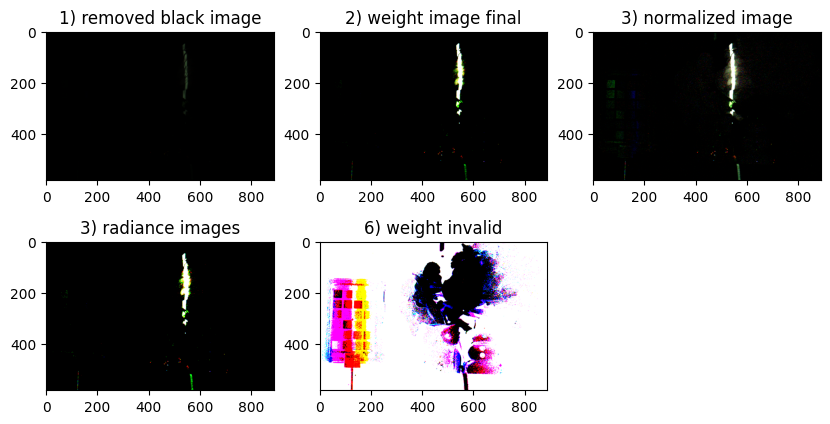

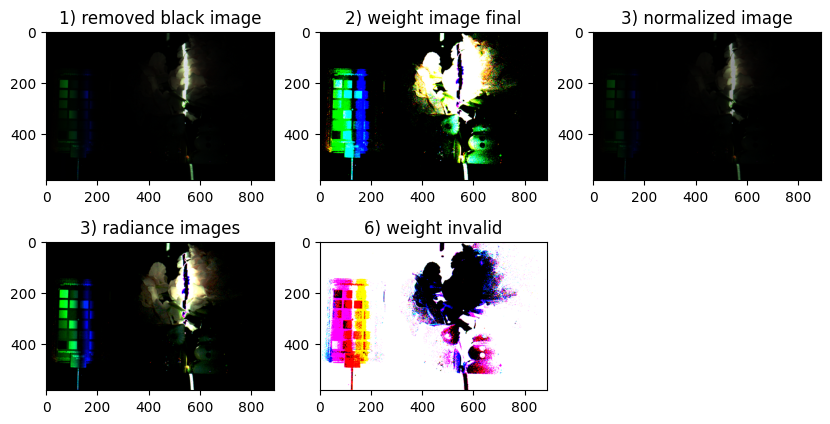

In [20]:
for i in range(len(ldr_images)):
    plt.figure(figsize = (10,5))
    plt.subplot(231), plt.imshow(ldr_images_bgrm[i] /65535), plt.title('1) removed black image')
    plt.subplot(232), plt.imshow(weighted_images_final[i]), plt.title('2) weight image final')
    plt.subplot(233), plt.imshow((ldr_images_bgrm[i] / (radiance_weight[i] * exposure[i]))/ 100000), plt.title('3) normalized image')
    plt.subplot(234), plt.imshow(radiance_images[i]/10000), plt.title('3) radiance images')

    plt.subplot(235), plt.imshow(idx_invalid.astype(np.uint8)*255), plt.title('6) weight invalid')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<AxesSubplot:title={'center':'4) HDR / HDR.max()'}>,
 Text(0.5, 1.0, '4) HDR / HDR.max()'))

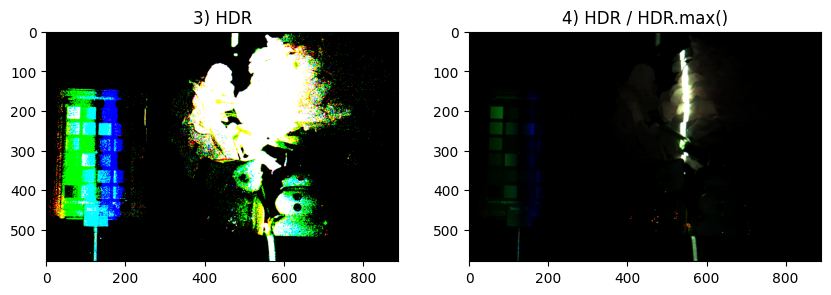

In [21]:
plt.figure(figsize = (10,5))
# plt.subplot(141), plt.imshow(radiance_sum_image), plt.title('1) radiance sum image')
# plt.subplot(142), plt.imshow(weight_sum_image / 3), plt.title('2) weight sum image')
hdr = radiance_sum_image / weight_sum_image
plt.subplot(121), plt.imshow(hdr), plt.title('3) HDR')
plt.subplot(122), plt.imshow(hdr/65535), plt.title('4) HDR / HDR.max()')

In [22]:
hdr_img = np.divide(radiance_sum_image, weight_sum_image)

In [23]:
hdr_img.max(), hdr_img.min()

(1083744.1264822136, 0.0)

In [24]:
hdr_img.max()

1083744.1264822136

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


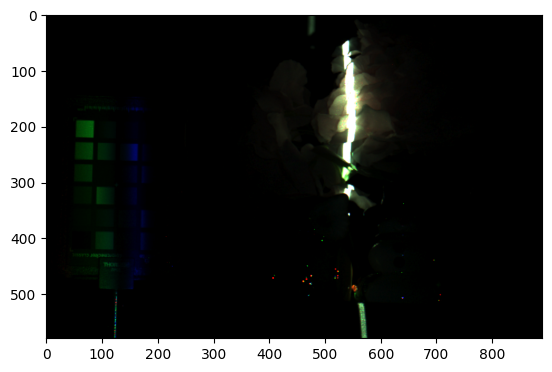

In [25]:
plt.imshow(hdr_img/65535)

### Make Hdr Image

In [28]:
hdr_imgs = []

# erase black image and get hdr image
for i in range(n_illum):    
    ldr_path = os.path.join(ldr2hdr_dir, 'step2_%sms_crop/calibration00/capture_%04d.png')
    black_path = os.path.join(ldr2hdr_dir, 'step2_%sms_black_crop/calibration00/capture_%04d.png')

    ldr_images = np.array([cv2.imread(ldr_path%(k, i), -1)[:,:,::-1] for k in ex_time])
    ldr_black_images = np.array([cv2.imread(black_path%(k, 0), -1)[:,:,::-1] for k in ex_time])
    
    # print(ldr_images.max(), ldr_images.min(), ldr_black_images.max(), ldr_black_images.min())    
    
    ldr_images_bgrm = np.clip(safe_subtract(ldr_images, ldr_black_images), 0., 2**16)
    ldr_images_bgrm = ldr_images_bgrm.astype(np.uint16)
    
    # print(final_ldr_images.max(), final_ldr_images.min())
        
    hdr_img, invalid_map, weight_map = make_hdr(ldr_images, ldr_images_bgrm, weight_trapezoid, exposure)
    hdr_imgs.append(hdr_img)

    if i % 10 == 0:
        print('%03d-th finished'%i)

hdr_imgs = np.array(hdr_imgs)

000-th finished
010-th finished
020-th finished
030-th finished
040-th finished
050-th finished
060-th finished
070-th finished
080-th finished
090-th finished
100-th finished
110-th finished
120-th finished
130-th finished
140-th finished
150-th finished
160-th finished
170-th finished
180-th finished
190-th finished
200-th finished
210-th finished
220-th finished
230-th finished
240-th finished
250-th finished
260-th finished
270-th finished
280-th finished
290-th finished
300-th finished
310-th finished


### For only 1 exposure

In [15]:
hdr_imgs_1 = []

exp_indx = 0

# ldr2hdr_dir = './calibration/ldr2hdr/20230907'

for i in range(318): 
    ldr_path = os.path.join(ldr2hdr_dir, 'step2_%sms_crop/calibration00/capture_%04d.png')
    black_path = os.path.join(ldr2hdr_dir, 'step2_%sms_black_crop/calibration00/capture_%04d.png')

    ldr_images = np.array(cv2.imread(ldr_path%(ex_time[exp_indx], i), -1)[:,:,::-1])
    ldr_black_images = np.array(cv2.imread(black_path%(ex_time[exp_indx], 0), -1)[:,:,::-1])

    # ldr_path = os.path.join(ldr2hdr_dir, 'space1_%sms/calibration00/capture_%04d.png')
    # black_path = os.path.join(ldr2hdr_dir, 'space1_%sms_black/calibration00/capture_%04d.png')

    # ldr_images = np.array(cv2.imread(ldr_path%(360, i), -1)[:,:,::-1])
    # ldr_black_images = np.array(cv2.imread(black_path%(360, 0), -1)[:,:,::-1])

    # print(ldr_images.max(), ldr_images.min(), ldr_black_images.max(), ldr_black_images.min())    

    # final_ldr_images = np.clip(safe_subtract(ldr_images, ldr_black_images), 0., 2**16)
    # final_ldr_images = final_ldr_images.astype(np.uint16)
    
    ldr_images_bgrm = np.clip(safe_subtract(ldr_images, ldr_black_images), 0., 2**16)
    ldr_images_bgrm = ldr_images_bgrm.astype(np.uint16)
    
    ldr_images = ldr_images[np.newaxis,:,:,:]
    ldr_images_bgrm = ldr_images_bgrm[np.newaxis,:,:,:]
    
    hdr_img, invalid_map, weight_map = make_hdr(ldr_images, ldr_images_bgrm, weight_trapezoid, exposure)
    hdr_imgs_1.append(hdr_img)

    if i % 10 == 0:
        print('%03d-th finished'%i)

    # hdr_imgs_1.append(final_ldr_images)
hdr_imgs_1 = np.array(hdr_imgs_1)

000-th finished
010-th finished
020-th finished


KeyboardInterrupt: 

### HDR Visualization Check

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


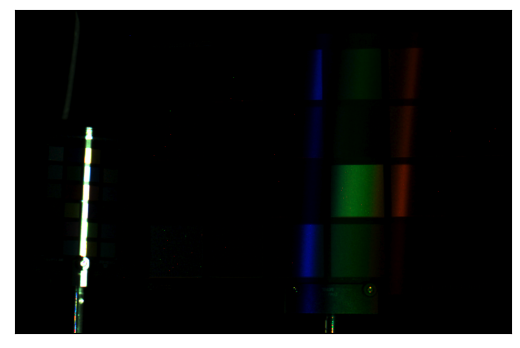

In [106]:
idx = 88
max_val = 65535

fig, ax = plt.subplots()
ax.imshow(hdr_imgs[idx] / (40000))
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

# plt.imshow(hdr_imgs[idx] / (65535))


## RGB Intensity Plotting

In [30]:
np.save('./hdr_step5_1022.npy', hdr_imgs)
# hdr_imgs = np.load('./hdr_step5.npy')

In [31]:
final_hdr = hdr_imgs.transpose(1,2,0,3)
# final_hdr = hdr_imgs_1.transpose(1,2,0,3)

In [32]:
# plot reflectance for each patches - real
# patches : 24개, wvl : 25 개
patches_rgb_real = np.zeros(shape = (n_illum, n_patches, n_channel))
patches_idx = all_patches_center_pts

cnst = 1
patch_size = 5


# max value defined for each illumination pattern 

for l in range(318):
        y_idx_start, y_idx_end = (patches_idx[:,1] - patch_size//2).astype(np.int32), (patches_idx[:,1] + patch_size//2).astype(np.int32)
        x_idx_start, x_idx_end = (patches_idx[:,0] - patch_size//2).astype(np.int32), (patches_idx[:,0] + patch_size//2).astype(np.int32)
        
        for p in range(n_patches):
                y_idx, x_idx = patches_idx[p,1], patches_idx[p,0]
                rgb_intensity = (final_hdr[y_idx_start[p]:y_idx_end[p], x_idx_start[p]:x_idx_end[p], l] / (65535)).reshape(-1, 3).mean(axis = 0)
                patches_rgb_real[l, p] = rgb_intensity

In [33]:
radiance_weight

array([[0.04698385, 0.04683648, 0.04654305],
       [1.        , 1.        , 1.        ]])

### Figure visulaization

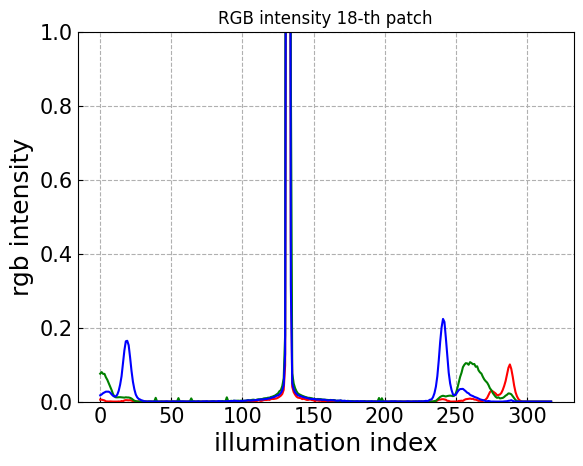

In [85]:
illum = np.arange(0, 318, 1)

start_idx = 0
end_idx = 318

# const = 0.04698385
const = 0.3

for p in range(18,19):
    fig, ax = plt.subplots()

    plt.plot(illum[start_idx: end_idx], patches_rgb_real[start_idx: end_idx, p, 0]*const, label = 'real red', c = 'red'),  plt.ylim(0,1)
    plt.plot(illum[start_idx: end_idx], patches_rgb_real[start_idx: end_idx, p, 1]*const, label = 'real green', c = 'green'),  plt.ylim(0,1)
    plt.plot(illum[start_idx: end_idx], patches_rgb_real[start_idx: end_idx, p, 2]*const, label = 'real blue', c = 'blue'),  plt.ylim(0,1)

    plt.grid(linestyle = '--')
    plt.title('RGB intensity %s-th patch'%patch_idx[p])
    plt.xlabel('illumination index', fontsize=18)
    plt.ylabel('rgb intensity',fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=15, direction = 'in')
    
    # plt.savefig('./%02d-th_patch.png'%(patch_idx[p]))

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take 

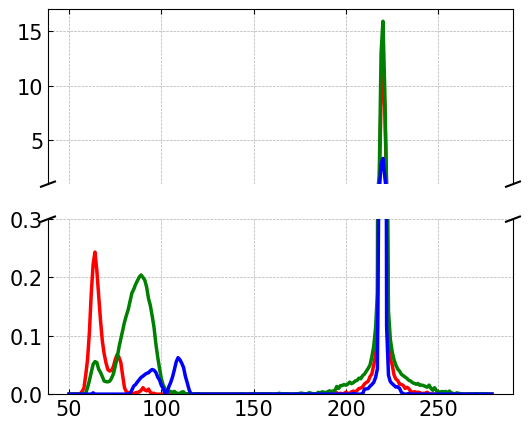

In [95]:
import numpy as np
import matplotlib.pyplot as plt
p = 15
start_idx = 50
end_idx = 280
# Sample data (replace with your own data)
x = illum[start_idx: end_idx]
y2_r = patches_rgb_real[start_idx: end_idx, p, 0]
y1_r = patches_rgb_real[start_idx: end_idx, p, 0]

y2_g = patches_rgb_real[start_idx: end_idx, p, 1]
y1_g = patches_rgb_real[start_idx: end_idx, p, 1]

y2_b = patches_rgb_real[start_idx: end_idx, p, 2]
y1_b = patches_rgb_real[start_idx: end_idx, p, 2]

# Create a figure and two subplots (stacked vertically)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 5))

# Plot the data in both subplots
ax1.plot(x, y2_r, 'g', c = 'red', linewidth = 2.5)  # top subplot (for the high values)
ax2.plot(x, y1_r, 'b', c = 'red', linewidth = 2.5) # bottom subplot (for the low values)

ax1.plot(x, y2_g, 'g', c = 'green', linewidth = 2.5)  # top subplot (for the high values)
ax2.plot(x, y1_g, 'b', c = 'green', linewidth = 2.5)

ax1.plot(x, y2_b, 'g', c = 'blue', linewidth = 2.5) # top subplot (for the high values)
ax2.plot(x, y1_b, 'b', c = 'blue', linewidth = 2.5)

# Set y-axis limits
ax1.set_ylim(1, 17)  # top subplot
ax2.set_ylim(0, 0.3)    # bottom subplot

# Hide spines between subplots
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()

# Create the appearance of a break between the subplots
d = .015  # size of the diagonal lines in the x and y axis coordinates
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom subplot coordinates
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# Display the plot
# Add grids to both subplots
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

ax1.tick_params(axis='both', which='major', labelsize=15, direction = 'in')
ax2.tick_params(axis='both', which='major', labelsize=15, direction = 'in')

plt.show()

### VIs

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


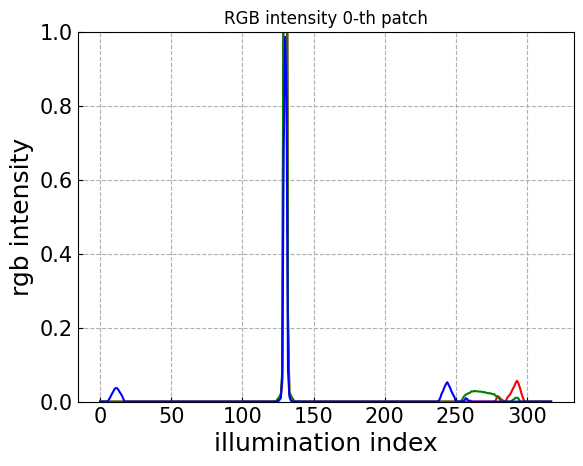

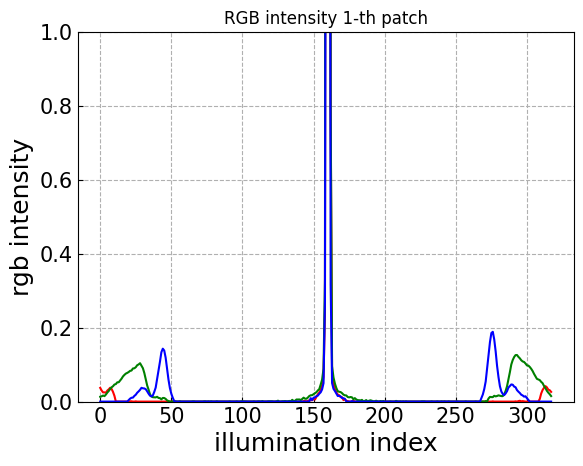

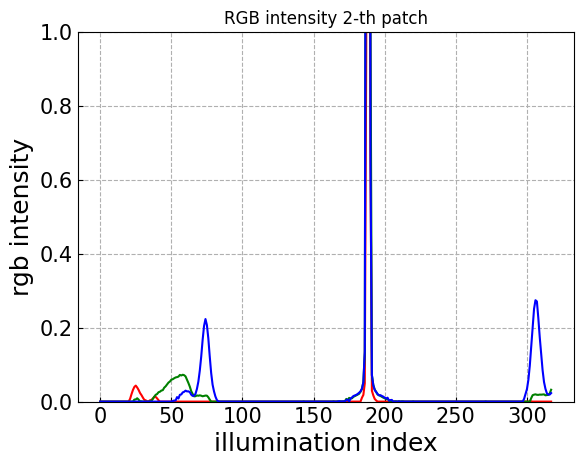

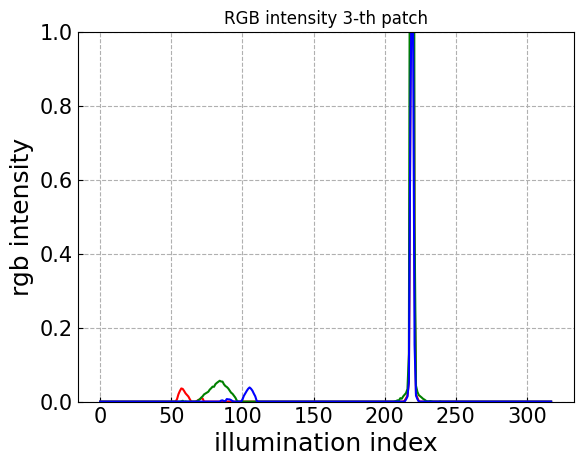

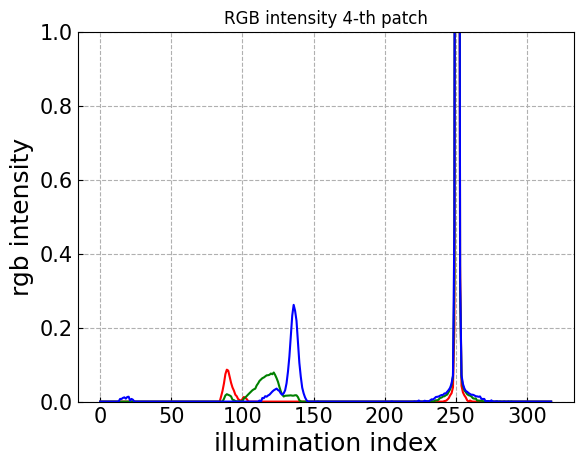

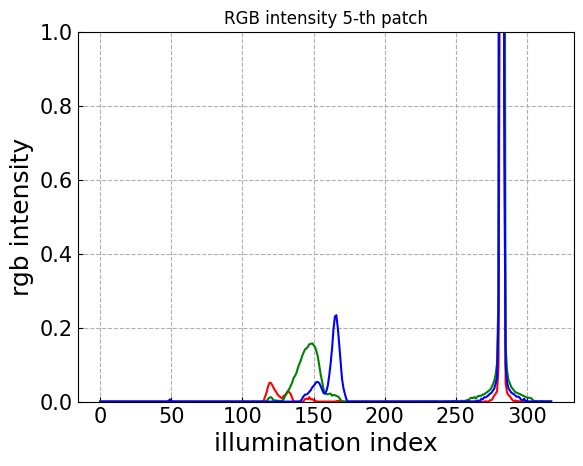

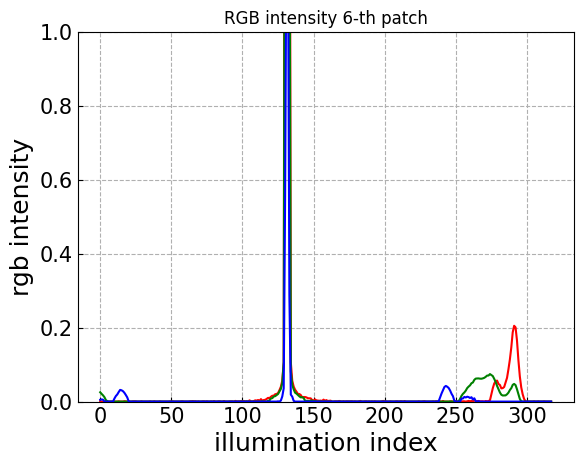

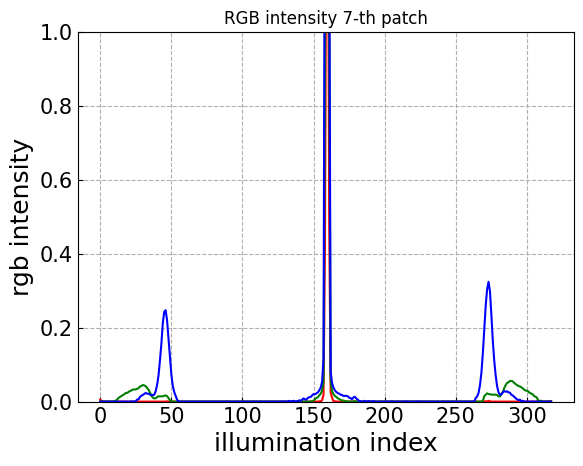

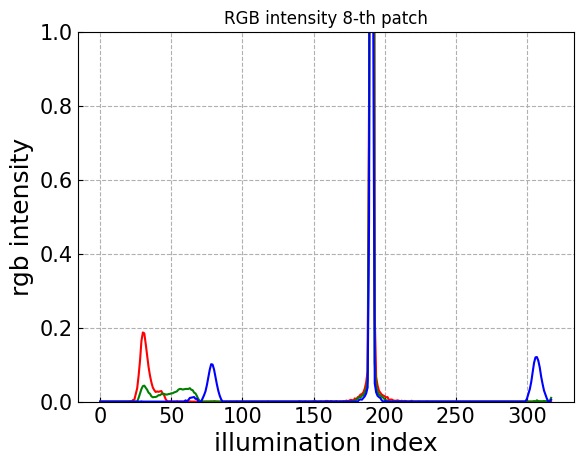

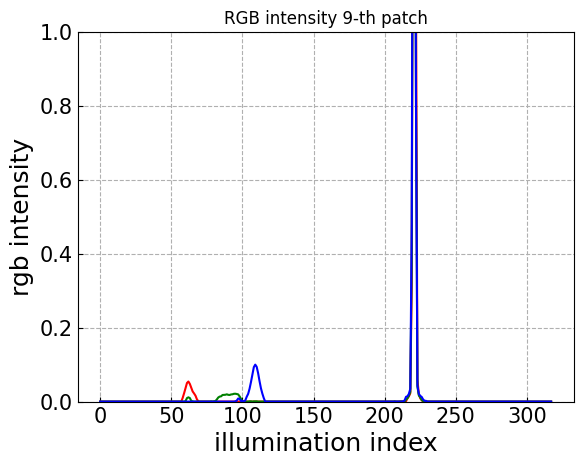

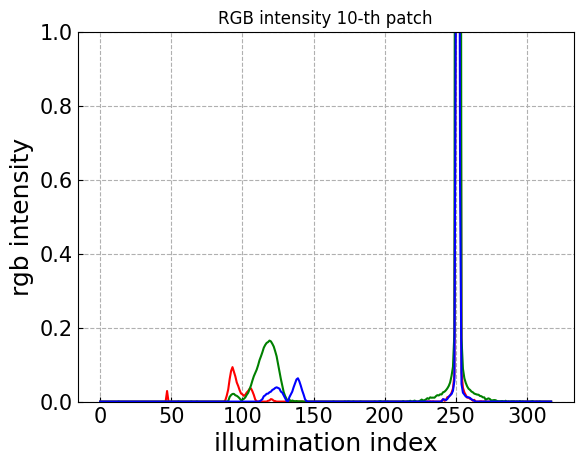

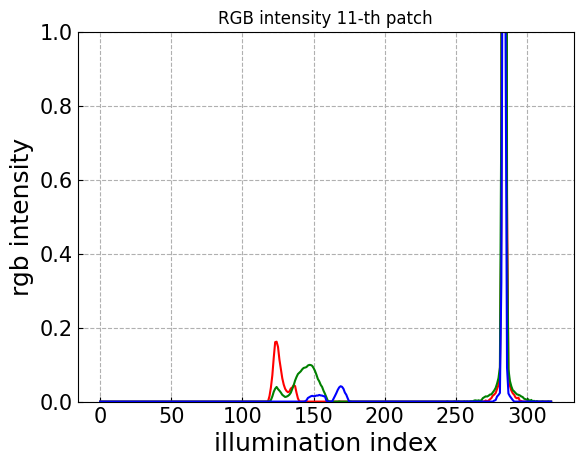

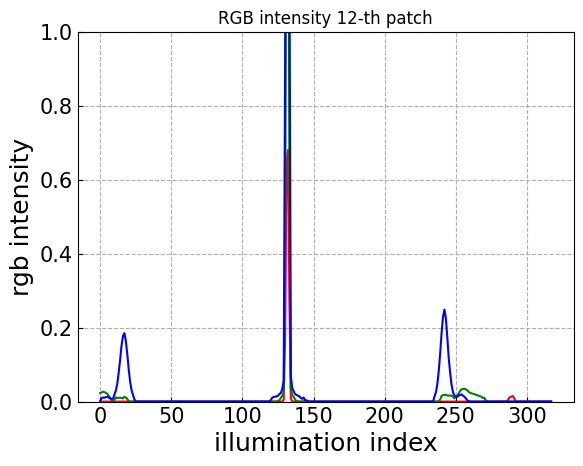

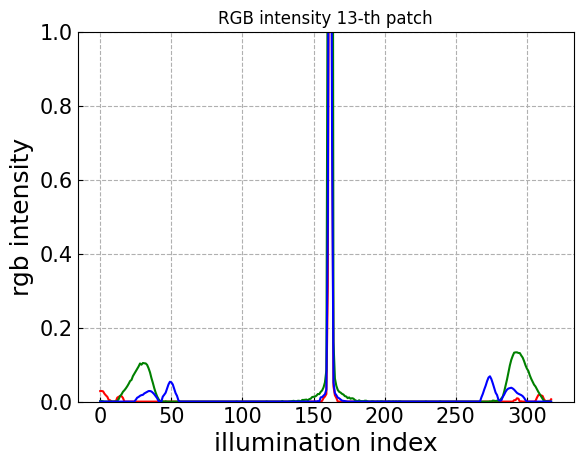

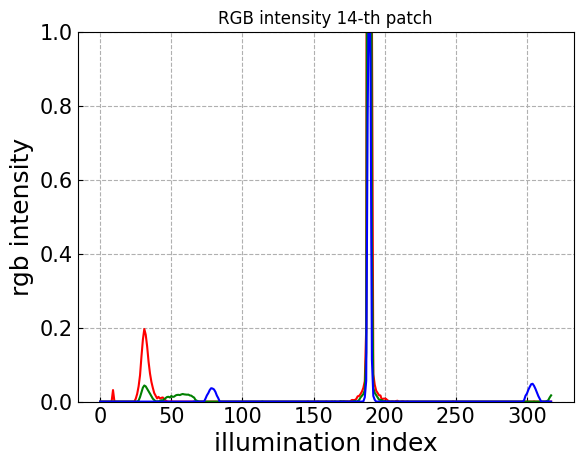

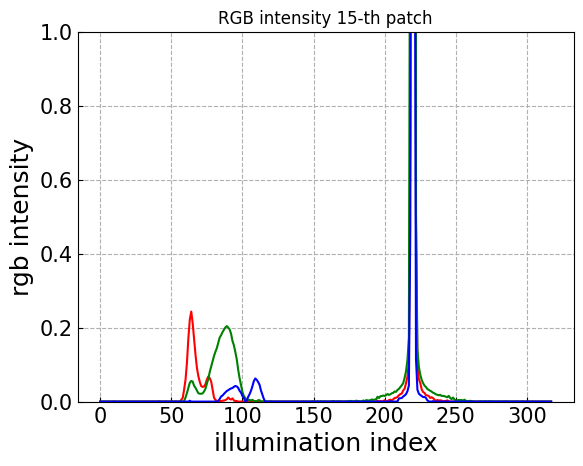

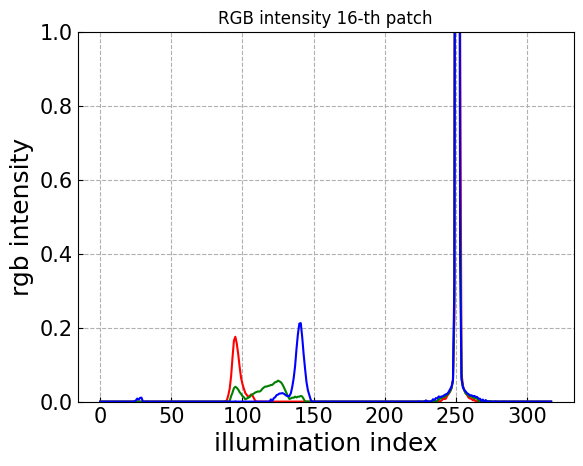

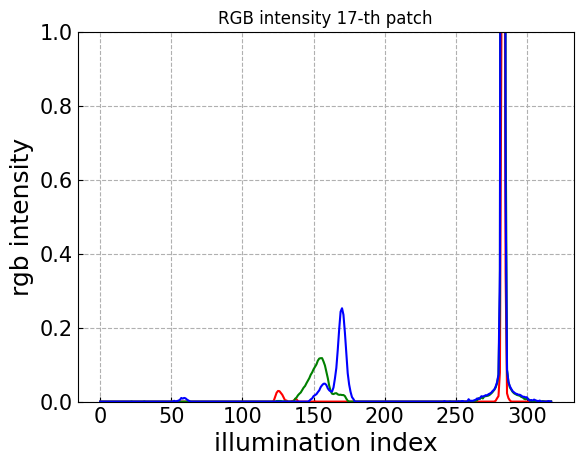

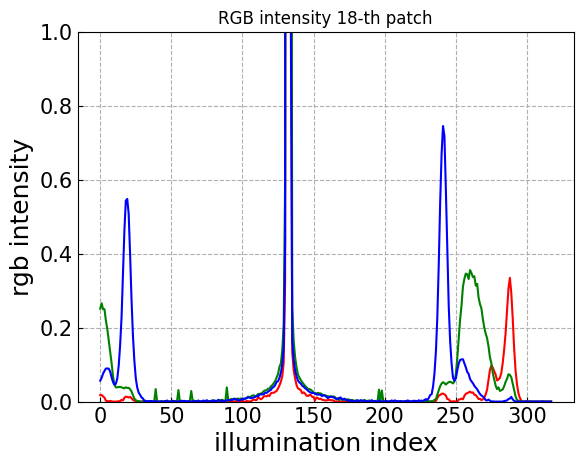

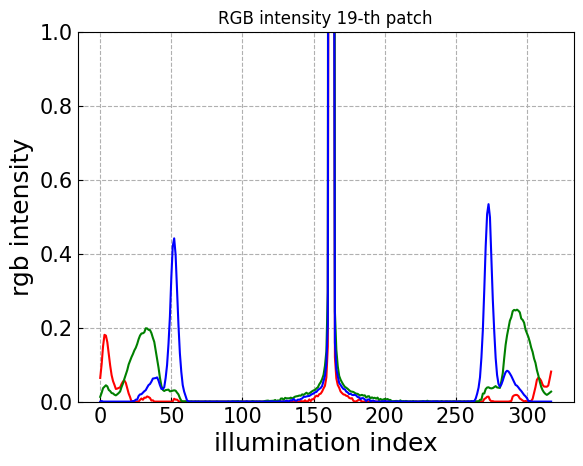

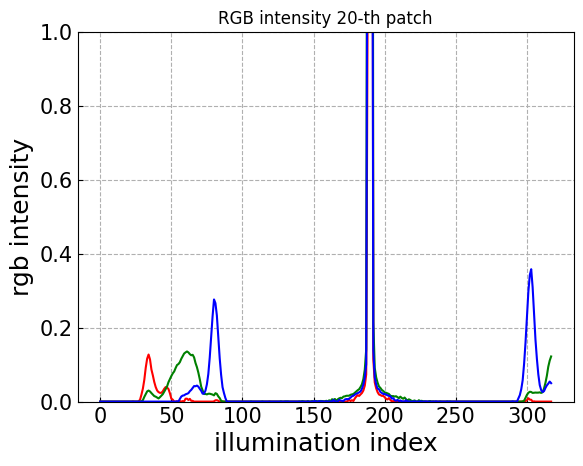

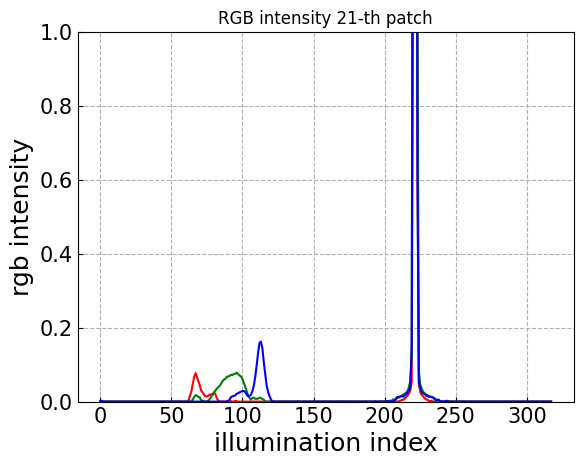

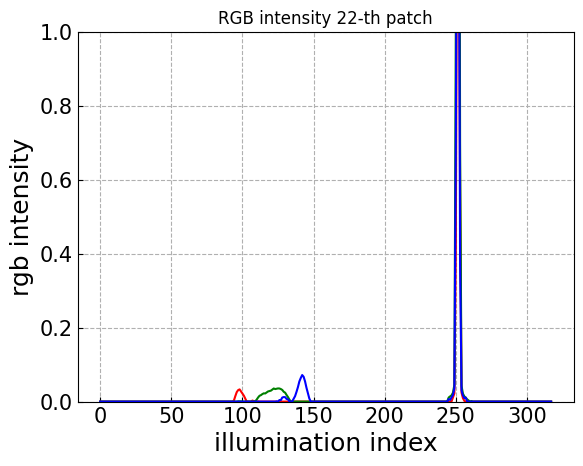

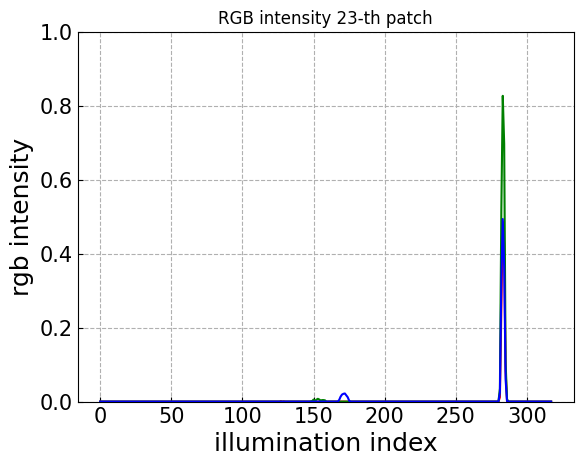

In [37]:
illum = np.arange(0, 318, 1)

start_idx = 0
end_idx = 318

for p in range(n_patches):
    fig, ax = plt.subplots()

    plt.plot(illum[start_idx: end_idx], patches_rgb_real[start_idx: end_idx, p, 0], label = 'real red', c = 'red'),  plt.ylim(0,1)
    plt.plot(illum[start_idx: end_idx], patches_rgb_real[start_idx: end_idx, p, 1], label = 'real green', c = 'green'),  plt.ylim(0,1)
    plt.plot(illum[start_idx: end_idx], patches_rgb_real[start_idx: end_idx, p, 2], label = 'real blue', c = 'blue'),  plt.ylim(0,1)

    plt.grid(linestyle = '--')
    plt.title('RGB intensity %s-th patch'%patch_idx[p])
    plt.xlabel('illumination index', fontsize=18)
    plt.ylabel('rgb intensity',fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=15, direction = 'in')
    
    # plt.savefig('./%02d-th_patch.png'%(patch_idx[p]))

## Hyperspectral Reconstruction Feasibility Test

In [ ]:
dg_intensity = np.load('./dataset/image_formation/dg_efficiency.npy')[1:] # from 430nm

(24, 3)


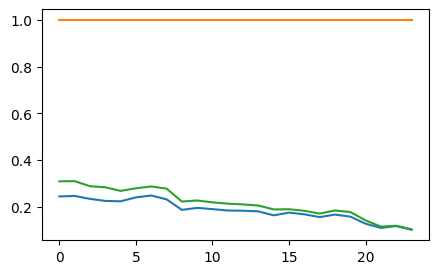

In [ ]:
print(dg_intensity.shape)
plt.figure(figsize=(5,3))
plt.plot(dg_intensity)

In [ ]:
# CRF PEF constant
radio_constant = np.load('./calibration/radiometric_cal/opt_params/opt_param_detach_%05d.npy'%9500)

# bring initial value of PEF and CRF
PEF = np.load('./dataset/image_formation/CRF_proj.npy')
map_scale = interp1d([PEF.min(), PEF.max()], [0.,1])
PEF = map_scale(PEF).astype(np.float32)
# PEF = PEF[3:27] * radio_constant[1:,:3]
PEF = PEF[3:27] * 0.5

CRF = np.load('./dataset/image_formation/CRF.npy')[:,1:].T #* radio_constant[1:,3:]

(<AxesSubplot:>,
  <matplotlib.lines.Line2D at 0x216d333a108>])

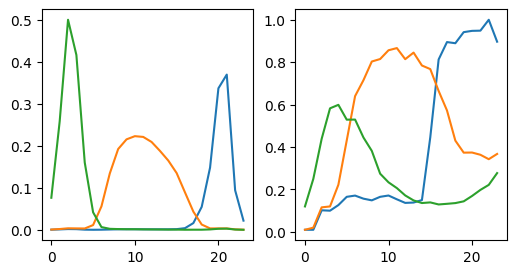

In [ ]:
plt.figure(figsize=(6, 3))
plt.subplot(121), plt.plot(PEF)
plt.subplot(122), plt.plot(CRF)

## Hyperspectral Reconstruction Processing data

In [ ]:
# white patch number 18
patch_num = 18

#### interpolation for 630nm

In [ ]:
# bring peak illumination index
peak_illum_idx = np.load('./peak_illum_idx.npy')

In [ ]:
def cubic_interpolation(x_new, x_points, y_points, n):
    tck = interpolate.splrep(x_points, y_points, k=n)   # Estimate the polynomial of nth degree by using x_points and y_points
    y_new = interpolate.splev(x_new, tck)
    return y_new

# wvls from 430 ~ 660 without 630nm
wvls = np.arange(430, 670, 10)
wvls = np.delete(wvls, -4)
wvls = torch.tensor(wvls)*1e-9
new_wvls = torch.linspace(430*1e-9, 660*1e-9, 24) # 400 ~ 680 까지 10nm 간격으로

# interpolated index 430 ~ 660 nm for 10nm interval
peak_illum_idx_intp = cubic_interpolation(new_wvls, wvls, peak_illum_idx[patch_num], 4).astype(np.int16)

# 430nm position
position_430nm = peak_illum_idx_intp[0]
# 660nm position
position_660nm  = peak_illum_idx_intp[-1]

[202 207 208 209 213 215 219 219 222 225 228 231 231 236 238 238 243 244
 248 250 252 255 256 259]


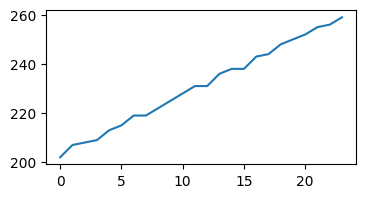

In [ ]:
# interpolated illumination index plotting
print(peak_illum_idx_intp)
plt.figure(figsize=(4,2))
plt.plot(peak_illum_idx_intp) # white patch

In [ ]:
patches_rgb_real.shape, position_430nm, position_660nm

((318, 24, 3), 202, 259)

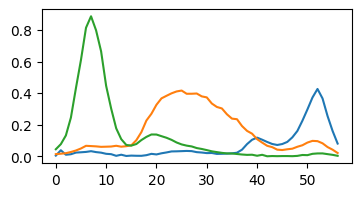

In [ ]:
# Real captured first order intensity with known position range (430nm to 660nm)

plt.figure(figsize=(4,2))
plt.plot(patches_rgb_real[position_430nm:position_660nm, patch_num]) # 78 ~ 102 총 25개

#### 5nm interval data sampling

In [ ]:
start_idx = position_430nm.astype(np.int16)
end_idx = position_660nm.astype(np.int16)

interval_array = np.linspace(start_idx, end_idx, 47)
interval_array = np.round(interval_array).astype(np.int16)
print(interval_array)

[202 203 204 206 207 208 209 211 212 213 214 216 217 218 219 221 222 223
 224 226 227 228 229 230 232 233 234 235 237 238 239 240 242 243 244 245
 247 248 249 250 252 253 254 255 257 258 259]


In [ ]:
# white_patch_rgb = patches_rgb_real[peak_illum_idx_intp.astype(np.int16), patch_num]
white_patch_rgb = patches_rgb_real[interval_array, patch_num]

(<AxesSubplot:title={'center':'original signal'}>,
 Text(0.5, 1.0, 'original signal'))

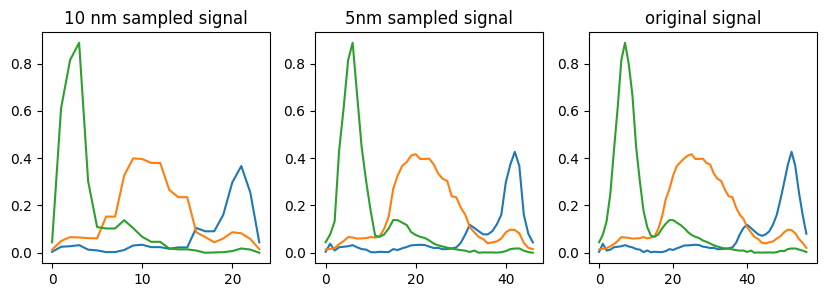

In [ ]:
plt.figure(figsize=(10,3))
plt.subplot(131), plt.plot(patches_rgb_real[peak_illum_idx_intp, patch_num]), plt.title('10 nm sampled signal')
plt.subplot(132), plt.plot(white_patch_rgb), plt.title('5nm sampled signal')
plt.subplot(133), plt.plot(patches_rgb_real[position_430nm:position_660nm, patch_num]), plt.title('original signal')

#### CRF, PEF interpolation

In [ ]:
def cubic_interpolation(x_new, x_points, y_points, n):
    tck = interpolate.splrep(x_points, y_points, k=n)   # Estimate the polynomial of nth degree by using x_points and y_points
    y_new = interpolate.splev(x_new, tck)
    return y_new

# wvls from 430 ~ 660 without 630nm
wvls = np.arange(430, 670, 10)
wvls = torch.tensor(wvls)*1e-9
new_wvls = torch.linspace(430*1e-9, 660*1e-9, 47) # 400 ~ 680 까지 10nm 간격으로

In [ ]:
# interpolated CRF for 5nm
CRF_R = cubic_interpolation(new_wvls, wvls, CRF[:,0], 4)
CRF_G = cubic_interpolation(new_wvls, wvls, CRF[:,1], 4)
CRF_B = cubic_interpolation(new_wvls, wvls, CRF[:,2], 4)

# interpolated PEF for 5nm
PEF_R = cubic_interpolation(new_wvls, wvls, PEF[:,0], 4)
PEF_G = cubic_interpolation(new_wvls, wvls, PEF[:,1], 4)
PEF_B = cubic_interpolation(new_wvls, wvls, PEF[:,2], 4)

In [ ]:
CRF_intp = np.stack((CRF_R, CRF_G, CRF_B))
PEF_intp = np.stack((PEF_R, PEF_G, PEF_B))

(<AxesSubplot:title={'center':'5nm interpolated PEF'}>,
 Text(0.5, 1.0, '5nm interpolated PEF'))

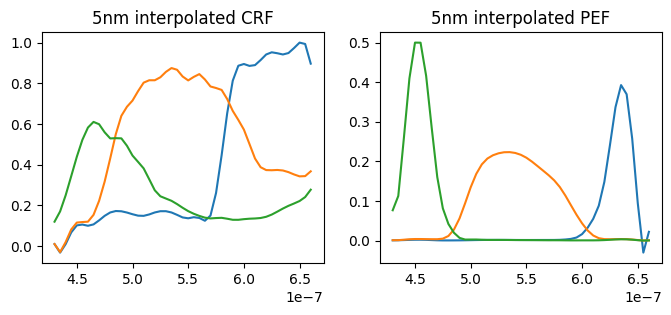

In [ ]:
plt.figure(figsize=(8,3))
plt.subplot(121), plt.plot(new_wvls, CRF_intp.T), plt.title('5nm interpolated CRF')
plt.subplot(122), plt.plot(new_wvls, PEF_intp.T), plt.title('5nm interpolated PEF')

#### Dg efficiency interpolation

In [ ]:
# interpolated CRF for 5nm
dg_intensity_R = cubic_interpolation(new_wvls, wvls, dg_intensity[:,0], 4)
dg_intensity_G = cubic_interpolation(new_wvls, wvls, dg_intensity[:,1], 4)
dg_intensity_B = cubic_interpolation(new_wvls, wvls, dg_intensity[:,2], 4)

In [ ]:
dg_intensity_intp = np.stack((dg_intensity_R, dg_intensity_G, dg_intensity_B))

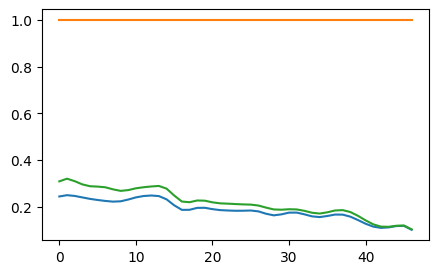

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(dg_intensity_intp.T)

#### GT reflectance, simulate first order RGB intensity 

In [ ]:
# interpolate GT reflectance for 5nm interval
ref_CC_intp = cubic_interpolation(new_wvls, wvls, ref_CC[2:-2,patch_num], 4)

# white pattern
white_patt = np.ones(shape = (1, 3)) * 0.8
white_patt_hyp = white_patt @ PEF_intp
white_patt_hyp = white_patt_hyp.squeeze()

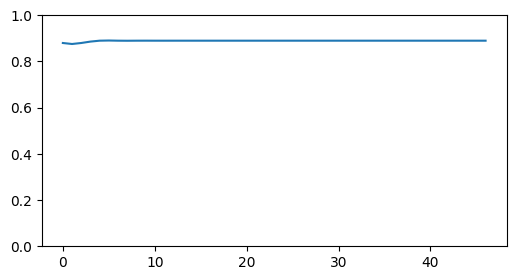

In [ ]:
plt.figure(figsize=(6,3))
plt.ylim([0, 1])
plt.plot(ref_CC_intp)

In [ ]:
# test with GT reflectance for all patches
total_patch = []
for p in range(n_patches):
    I_C = ref_CC_intp[:,np.newaxis] * CRF_intp.T * white_patt_hyp[:,np.newaxis] * dg_intensity_intp[2][:,np.newaxis]
    # I_C = ref_CC[2:-2,p][:,np.newaxis] * CRF * white_patt_hyp[:,np.newaxis] * dg_intensity[:,2][:,np.newaxis]

    total_patch.append(I_C)

In [ ]:
white_patch_rgb.shape

(47, 3)

In [ ]:
constant = 18
max_ylim = 0.9

# plot 1st order rgb intensity for all patches
for p in range(patch_num, patch_num+1): # only visualize white patch
    plt.figure(figsize=(10,3))
    plt.ylim([0, 1])
    
    # red
    plt.subplot(131), plt.plot(total_patch[p][:,0] * constant, c = 'red', label = 'simulation red')
    plt.subplot(131), plt.plot(white_patch_rgb[:,0], c = 'orange', label = 'real captured red')
    plt.legend()
    plt.ylim([0, max_ylim])
    
    # green
    plt.subplot(132), plt.plot(total_patch[p][:,1]* constant, c = 'green', label = 'simulation red green')
    plt.subplot(132), plt.plot(white_patch_rgb[:,1], c = 'lime', label = 'real captured green')
    plt.legend()
    plt.ylim([0, max_ylim])
    
    # blue
    plt.subplot(133), plt.plot(total_patch[p][:,2]* constant, c = 'blue', label = 'simulation red blue')
    plt.subplot(133), plt.plot(white_patch_rgb[:,2], c = 'royalblue', label = 'real captured blue')
    plt.ylim([0, max_ylim])
    
    plt.title('%s-th patch'%p)
    plt.legend()

NameError: name 'patch_num' is not defined

#### Reconstruction with 5nm interval

In [ ]:
# white pattern
white_patt = np.ones(shape = (1, 3)) * 0.8
white_patt_hyp = white_patt @ PEF_intp
white_patt_hyp = white_patt_hyp.squeeze()

In [ ]:
# summation of CRF RGB channel
CRF_sum = CRF_intp.T.sum(axis = 1)

# summation of Image RGB channel
I_C = white_patch_rgb.sum(axis = 1) * (1/constant)

In [ ]:
# simulated first order rgb intensity reconstruction
# hyp_ref = (total_patch[patch_num].sum(axis = 1) / ( CRF_sum * white_patt_hyp * dg_intensity_intp[2]))

# real captured first order rgb intensity reconstruction
hyp_ref = (I_C / ( CRF_sum * white_patt_hyp * dg_intensity_intp[2]))

In [ ]:
# map_scale = interp1d([hyp_ref.min(), hyp_ref.max()], [0.,1])
# hyp_ref = map_scale(hyp_ref).astype(np.float32)

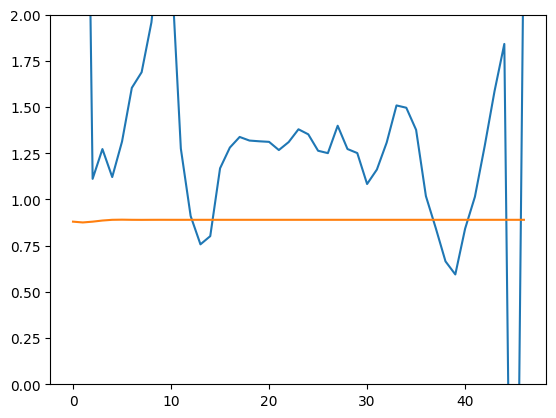

In [ ]:
plt.ylim([0,2])
plt.plot(hyp_ref)
plt.plot(ref_CC_intp)

### 